In [1]:
import numpy as np
import cv2 as cv     
from spectral import *
from matplotlib import pyplot as plt

from typing import Tuple

In [2]:
HSI_CUBE_PATHS = ['1.npy', '2.npy', '3.npy']
KINECT_IMG_PATH = 'top_down.png'

hsi = []
cumulative_hsi = None
perspective_transforms = []

In [3]:
# Radiometric calibration - HSI
dark_img = open_image('./darkReference.hdr')
data_dark = np.array(dark_img.load()).reshape(640,273)
white_img = open_image('./whiteReference.hdr')
data_white = np.array(white_img.load()).reshape(640,273)

# Radiometric calibration - Spectrometer
dark_ref_spec = np.mean(data_dark, axis=0)
white_ref_spec = np.mean(data_white, axis=0)

In [4]:
# Given a cube, create an indicative greyscale image
def create_image_from_cube(raw_cube: np.ndarray) -> np.ndarray:
    # Normalize the cube based off of radiometric calibration
    cal_cube = np.zeros_like(raw_cube,dtype=np.float32)
    for i in range(raw_cube.shape[0]):
        cal_cube[i,:,:] = np.clip((raw_cube[i,:,:] - data_dark) / (data_white - data_dark),0,1)* 255
        
    # copy indicative bands from hsi cube into rgb values for corresponding pixels
    adapted = np.zeros([len(raw_cube), len(raw_cube[0]), 3], dtype=np.uint16)
    adapted[:,:,0] = cal_cube[:,:,140]
    adapted[:,:,1] = cal_cube[:,:,63] 
    adapted[:,:,2] = cal_cube[:,:,36]
    adapted = cv.convertScaleAbs(adapted) # Convert to correct datatype for visualization
    adapted = cv.cvtColor(adapted, cv.COLOR_BGR2GRAY) # convert to greyscale

    # Transform the image to match the RGB image
    adapted = cv.flip(adapted, 0)
    adapted = cv.rotate(adapted, cv.cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return adapted

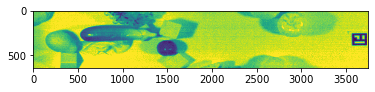

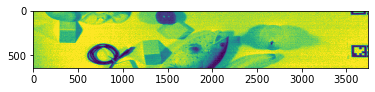

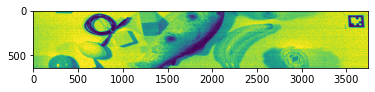

In [5]:
# Process each cube from the list of filepaths to create an indicative greyscale image, then add it to the list of images
for cube_path in HSI_CUBE_PATHS:
    img = create_image_from_cube(np.load(cube_path))
    hsi.append(img)
    
for image in hsi:
    plt.figure()
    plt.imshow(image)

In [6]:
MIN_MATCH_COUNT = 10
sift = cv.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Given two images, returns the perspective transform between the child and parent
def determine_homography(child: np.ndarray, parent: np.ndarray) -> np.ndarray:
    kp1, des1 = sift.detectAndCompute(child, None)
    kp2, des2 = sift.detectAndCompute(parent, None)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    for m, n in matches:
        if m.distance < .8 * n.distance: #tutorial has 0.7*n.distance, increase thresh for more matches
            good.append(m)
    
    assert len(good) > MIN_MATCH_COUNT, f"Needed to find {MIN_MATCH_COUNT} matches, instead only found {len(good)}"

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    return M

In [7]:
# Given two images and their perspective transform, combine the two images, and return the transform 
def warpTwoImages(child: np.ndarray, parent: np.ndarray, M: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''warp parent to child with homograph M'''
    h1,w1 = child.shape[:2]
    h2,w2 = parent.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv.perspectiveTransform(pts2, M)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    H =  Ht.dot(M)
    result = cv.warpPerspective(parent, H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = child
    return result, H

True

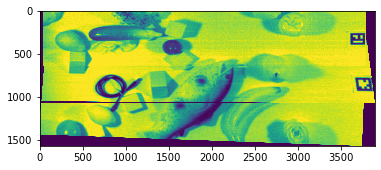

In [8]:
assert len(hsi) >= 1, "Need at least one image"

if(cumulative_hsi is None):
    cumulative_hsi = hsi[0]
    hsi.remove(hsi[0])
    M = determine_homography(hsi[0], hsi[0])
    comb, H = warpTwoImages(hsi[0], hsi[0], M)

for x in range(len(hsi)):
    M = determine_homography(hsi[x], cumulative_hsi)
    cumulative_hsi, H = warpTwoImages(cumulative_hsi, hsi[x], M)
    perspective_transforms.append(H)

plt.imshow(cumulative_hsi)
cv.imwrite("cumulative.png", cumulative_hsi)


True

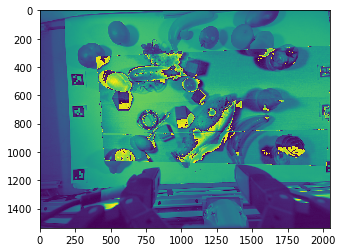

In [12]:
kinect_img = cv.imread(KINECT_IMG_PATH, 0)
M = determine_homography(cumulative_hsi, kinect_img)
h, w = kinect_img.shape

cumulative_hsi = cv.warpPerspective(cumulative_hsi, M, (w, h))
overlay = kinect_img + cumulative_hsi
plt.imshow(overlay)
cv.imwrite("overlay.png", overlay)